# Calculating DRT

This package estimates DRT by generating a Voigt circuit model and fitting its parameters using `LsqFit.jl`. The concept can be broken down simply: any impedance $Z(\omega)$ can be generated by a series of RC pairs:
$$
Z(\omega) = \sum_i^\infty \frac{R_i}{1+i\omega\tau_i},\\ \tau_i = R_iC_i
$$
This is analogous to a fourier transform for generic functions. Let's look at some examples.

In [1]:
using EISAnalysis

First, let's consider a simple circuit with 2 RC pairs

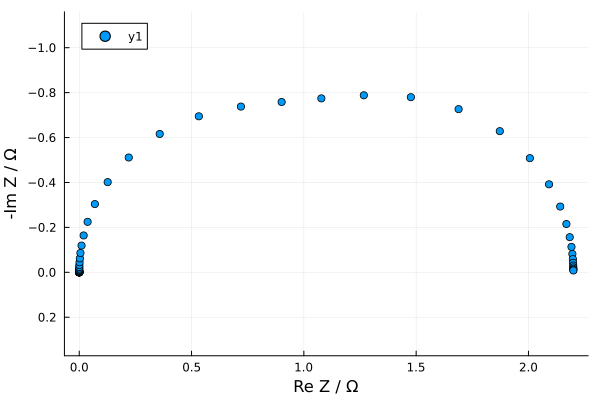

In [2]:
rc_circuit = r/c-1.2r/5c
plot_Nyquist(rc_circuit)

You can fit this to a Voigt circuit and estimate the DRT. The expanded fit includes the individual contribution from each RC pair in the Voigt circuit model and acts as a visual aid in interpreting the DRT plot.

rtol = 0.0001025603909245873


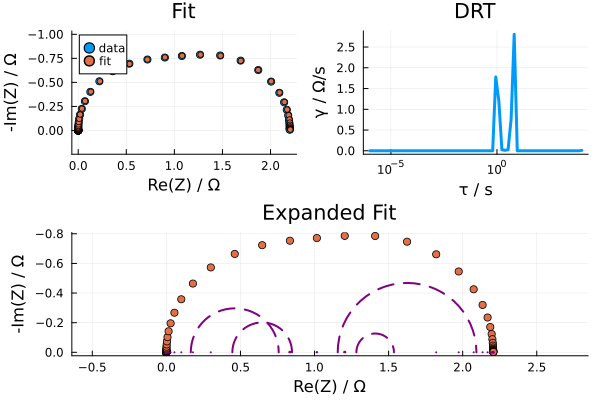

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[1.08332e-10-1.21579e-5im, 2.09157e-10-1.68933e-5im, 4.038…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.0
  "drt" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0,…

In [3]:
rc_fit = compute_drt(rc_circuit.ω,rc_circuit.Z;ppd=7)

Constant-phase elements are used to capture capacative (non-faradaic) processes which are non-ideal, and this is reflected in the gaussian shape of the DRT.

rtol = 1.3538170577530849e-14


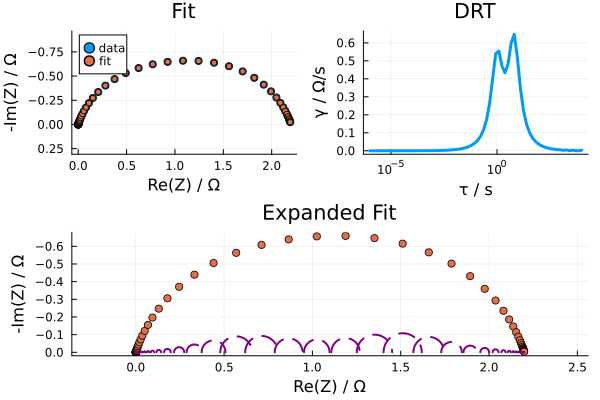

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[3.94376e-5-0.000121343im, 5.13126e-5-0.000157868im, 6.676…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 1.81578e-6
  "drt" => [1.66272e-5, 1.11948e-6, 1.35742e-6, 1.58707e-5, 0.0, 2.71399e-5, 8.…

In [4]:
rq_circuit = r/q-1.2r/5q
rq_fit = compute_drt(rq_circuit.ω,rq_circuit.Z)

Now for more complicated circuits

rtol = 3.0174193847489767e-6


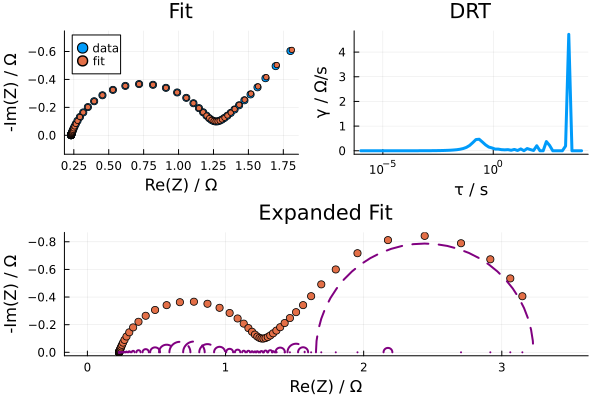

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.230112-0.000344577im, 0.230146-0.000448272im, 0.23019-0…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.230006
  "drt" => [2.57668e-6, 7.02776e-5, 5.23584e-8, 8.56084e-6, 7.59665e-6, 9.76994…

In [5]:
randles_circuit = 0.23r-(r-0.025ws^80)/0.2q
randles_fit = compute_drt(randles_circuit.ω,randles_circuit.Z)

Now let's try to fit to experimental data. I found this dataset on Mendeley

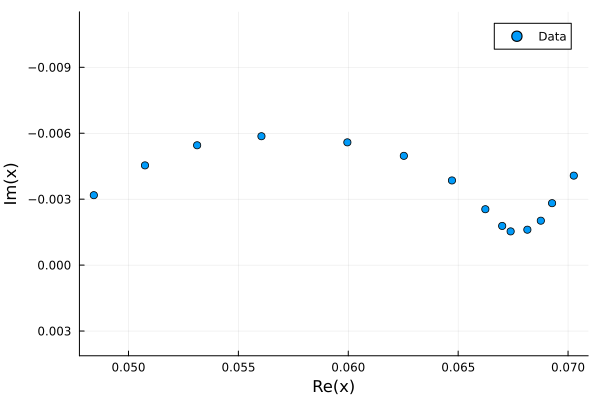

In [6]:
using CSV,DataFrames,Plots

omega_data =  [ 0.05, 0.1, 0.2, 0.4, 1, 2, 4, 10, 20, 40, 100, 200, 400, 1000]
Zs = CSV.read("Data/EIS_Data.csv",DataFrame)
Z_data = Zs[!,"Re(Z)"] -im*Zs[!,"-Im(Z)"]
data = [(omega_data,Z_data)]

scatter(Z_data,label = "Data",yflip=true,aspect_ratio=:equal)

rtol = 5.902724989708208e-7


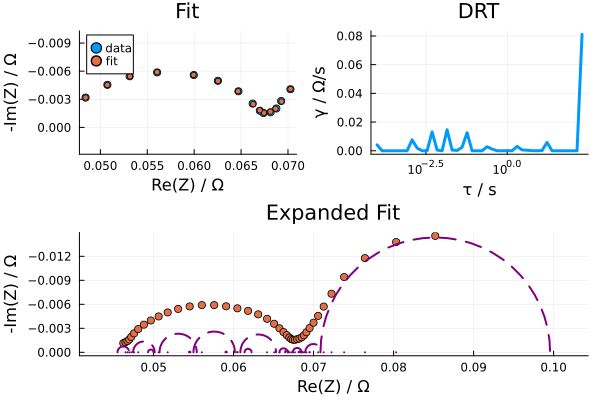

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.0702692-0.00409078im, 0.0693075-0.00276616im, 0.0686769…
  "τ"   => LogRange{Float64}(0.0001, 200.0, 42)
  "R0"  => 0.0454725
  "drt" => [0.00411331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00763166, 0.00191775, 0…

In [7]:
fit = compute_drt(omega_data,Z_data;regularization=false)